<a href="https://colab.research.google.com/github/charris6/Spotify/blob/main/Project4_SpotifyMaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project should be done using tree-based regression techniques as covered in class. The parameters of the trees should be carefully selected to avoid over-fitting.


There are two main challenges for this project:

1. Choosing appropriate predictors. When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



##Business Problem

We've been given a dataset from Spotify tracking several variables about individual songs. These include both performance metrics like total streams and charting, as well as analysis on each song's composition measuring things like acousticness, tempo, etc. From this we've been tasked with determining what makes a song popular. We'll be using supervised regression models tuned with a goal of lowering our RMSE.

##Imports

In [278]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import plotly.express as px

In [279]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: 6VWGo33IcuWvUB/o8uuO/uTD0n+Y53Wv0M38ZsSCy+UFOACxF3nOe3SBschJCJZnxsGSR9Li0+4=
x-amz-request-id: A5YJQHZQM9AWT3ZJ
Date: Wed, 06 Mar 2024 17:40:41 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Server: AmazonS3
Content-Length: 738124



##EDA

First thing is selecting a target. Potential options among our columns include streams, popularity, and the charting metrics. I'm going with total streams, since that's the entire point of these platforms for recording artists. They get paid on a per stream basis, so that's more valuable than anything else in my opinion.

In [280]:
df_spotify = pd.read_csv(url)
df_spotify.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


We see below that there are 1,556 songs in our dataset. This is something to keep in mind as I'll be winnowing this number down throughout this process. In other words, I don't want to end up only using a couple hundred songs for my models.

In [281]:
df_spotify.shape

(1556, 23)

Next up I want to see the datatypes of our columns. Many of the numbers are in fact objects, which will need to be addressed later.

In [282]:
df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

Now I'd like to see what unique identifiers we have. Index and Song ID seem like obvious candidates.

In [283]:
df_spotify['Index'].value_counts().sort_values(ascending=False)

1       1
49      1
3       1
4       1
5       1
       ..
1555    1
1546    1
1534    1
1533    1
1556    1
Name: Index, Length: 1556, dtype: int64

In [284]:
df_spotify['Song ID'].value_counts().sort_values(ascending=False)

                          11
5uEYRdEIh9Bo4fpjDd4Na9     3
3yZCjDTxzZxx1kll1sRjGc     2
07Oz5StQ7GRoygNLaXs2pd     2
2AlYncTpVHKwHb55F9lF6O     2
                          ..
1VJwtWR6z7SpZRwipI12be     1
62zKJrpbLxz6InR3tGyr7o     1
2bPtwnrpFNEe8N7Q85kLHw     1
3wwo0bJvDSorOpNfzEkfXx     1
3i9UVldZOE0aD0JnyfAZZ0     1
Name: Song ID, Length: 1517, dtype: int64

##Data Cleaning

Unfortunately there are a few duplicate song IDs as we can see above. That top line with a value of 11 are songs that don't have any ID associated with them. Since we're only dealing with less than 50 duplicates, I'll just drop them. If I wanted to try and incorporate them into the dataset, I'd need to see if the streams should be added together and if the normalized features should be averaged.

In [285]:
unique_songs_df = df_spotify.drop_duplicates(subset=['Song ID'], keep=False)

I'm going to drop some columns below. Some are unique identifiers, others qualitative information (genre, artist, etc) and others still features that tie into popularity like charting information.

In [286]:
df_spotify_clean = unique_songs_df.drop(columns=['Song Name', 'Song ID', 'Genre', 'Week of Highest Charting', 'Weeks Charted', 'Index', 'Popularity', 'Number of Times Charted', 'Highest Charting Position'])
df_spotify_clean_no_artist = df_spotify_clean.drop(columns = ['Artist'])

I now need to clean my Streams column. The values are formatted with commas, so I should remove those.

In [287]:
df_spotify_clean_no_artist['Streams'] = df_spotify_clean_no_artist['Streams'].str.replace(',', '').astype(float)

I'm doing a couple of things in the codeblock below. First, I'm reformatting the Release Date column to datetime. Then I'm applying a couple of filters, one to cut my timeframe down to the five years prior to our dataset and another to eliminate any songs with more than 40 million streams. Finally I'm pulling out the day of the year from the release date. I set that date range, because some of our songs were released decades ago, so I'd rather look at what makes a song popular now as opposed to classic hits. Day of year is useful in determining if when a song is released affects its popularity.

In [288]:
df_spotify_clean_no_artist['Release Date'] = pd.to_datetime(df_spotify_clean_no_artist['Release Date'])

#Here I removed one outlier with more than 40 million streams and also set date parameters to limit the set to songs released in a recent five year period.
df_spotify_filtered = df_spotify_clean_no_artist[(df_spotify_clean_no_artist['Release Date'] <= '2021-01-01') & (df_spotify_clean_no_artist['Release Date'] >= '2016-01-01')].copy()
df_spotify_filtered = df_spotify_filtered[(df_spotify_filtered['Streams'] <= 40_000_000)].copy()
#I'm more concerned with the day of year than anything else for predictions, so I'm pulling that value out.
df_spotify_filtered['Day of Year'] = df_spotify_filtered['Release Date'].dt.dayofyear.astype(float)

In [289]:
df_spotify_filtered.shape

(1000, 14)

That leaves us with 1,000 songs. Below I one-hot encoded the Chord column, but it didn't improve the model. I'm leaving it here in case I wanted to pull it back in after doing some more tuning.

In [290]:
#chord_dummies = pd.get_dummies(df_spotify_filtered['Chord'], prefix='Chord')

#df_spotify_filtered = pd.concat([df_spotify_filtered, chord_dummies], axis=1)

##Processing

I've got my models and cross-validated RMSEs below. I attempted to do more feature selection based on the outputs, but the importance on the lower end changes during each run. One thing that is consistent is that Artist Followers and Day of the Year are among the most important in each model.

In [306]:
X = df_spotify_filtered.drop(columns=['Streams', 'Release Date', 'Chord'])
y = df_spotify_filtered['Streams']

results = {}

numLoops = 100

for i in range(1,6):
  mean_error = np.zeros(numLoops)
  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle = True, )
    model = DecisionTreeRegressor(max_depth = i)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mean_error[idx] = mean_squared_error(y_test, y_pred)
    results[f"Depth = {i}"] = mean_error

print(f'Decision Tree RMSE: {np.sqrt(mean_error).mean()}')

Decision Tree RMSE: 1727130.274295778


In [307]:
for k, v in results.items():
  print(f'{k} Decision Tree RMSE: {np.sqrt(v).mean()}')

Depth = 1 Decision Tree RMSE: 1633817.488895773
Depth = 2 Decision Tree RMSE: 1563316.517204467
Depth = 3 Decision Tree RMSE: 1539471.3610469021
Depth = 4 Decision Tree RMSE: 1589894.0731351655
Depth = 5 Decision Tree RMSE: 1727130.274295778


In [308]:
importances = model.feature_importances_

feature_importances_dt = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances_dt = feature_importances_dt.sort_values(by='Importance', ascending=False)

print(feature_importances_dt)

             Feature  Importance
0   Artist Followers    0.274900
10       Day of Year    0.211724
8      Duration (ms)    0.163093
4        Speechiness    0.086238
1       Danceability    0.085227
3           Loudness    0.054647
5       Acousticness    0.045547
6           Liveness    0.029311
9            Valence    0.022620
7              Tempo    0.017175
2             Energy    0.009518


In [294]:
X = df_spotify_filtered.drop(columns=['Streams', 'Release Date', 'Chord'])

results = {}

numLoops = 100

for i in range(1,6):
  mean_error = np.zeros(numLoops)
  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle = True, )
    random_forest_model = RandomForestRegressor(max_depth = i)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mean_error[idx] = mean_squared_error(y_test, y_pred)
    results[f"Depth = {i}"] = mean_error

print(f'Random Forest RMSE: {np.sqrt(mean_error).mean()}')

Random Forest RMSE: 1704911.701498999


In [295]:
for k, v in results.items():
  print(f'{k} Random Forest RMSE: {np.sqrt(v).mean()}')

Depth = 1 Random Forest RMSE: 1711399.2820080658
Depth = 2 Random Forest RMSE: 1697565.9399734854
Depth = 3 Random Forest RMSE: 1719205.682051769
Depth = 4 Random Forest RMSE: 1687585.08531213
Depth = 5 Random Forest RMSE: 1704911.701498999


In [296]:
importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importances_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances_rf)

             Feature  Importance
10       Day of Year    0.324907
0   Artist Followers    0.253090
8      Duration (ms)    0.140225
5       Acousticness    0.104694
1       Danceability    0.069326
7              Tempo    0.067981
2             Energy    0.013936
9            Valence    0.013310
6           Liveness    0.012532
3           Loudness    0.000000
4        Speechiness    0.000000


In [297]:
# Reset results
results = {}

# Define numLoops
numLoops = 100

# Define features and target
X = df_spotify_filtered.drop(columns=['Streams', 'Release Date', 'Chord'])
y = df_spotify_filtered['Streams']

# Convert all relevant columns to numeric
for column in X.columns:
    X[column] = pd.to_numeric(X[column], errors='coerce')

# Perform grid search
for i in range(1, 6):
    mean_error = np.zeros(numLoops)
    for idx in range(0, numLoops):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
        xgb_model = XGBRegressor(max_depth=i)
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        mean_error[idx] = mean_squared_error(y_test, y_pred_xgb)
    results[f"Depth = {i}"] = mean_error

# Print results
for depth, error in results.items():
    print(f'XGBRegressor RMSE (Depth={depth}): {np.sqrt(error).mean()}')

XGBRegressor RMSE (Depth=Depth = 1): 1554861.7753104777
XGBRegressor RMSE (Depth=Depth = 2): 1587325.243404862
XGBRegressor RMSE (Depth=Depth = 3): 1631517.1035213717
XGBRegressor RMSE (Depth=Depth = 4): 1644853.627417594
XGBRegressor RMSE (Depth=Depth = 5): 1667805.9332793406


In [298]:
importances = xgb_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importances_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances_xgb = feature_importances_xgb.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances_xgb)

             Feature  Importance
10       Day of Year    0.209448
0   Artist Followers    0.124260
8      Duration (ms)    0.102959
6           Liveness    0.099238
5       Acousticness    0.085010
7              Tempo    0.078679
4        Speechiness    0.072270
3           Loudness    0.065291
9            Valence    0.056116
1       Danceability    0.053785
2             Energy    0.052944


##Data Visualization/Communication of Results

In both the decision tree and random forest models, the most important features were Artist Followers, Release Day, and Duration. I've got those plotted against our target in the next three visualizations.

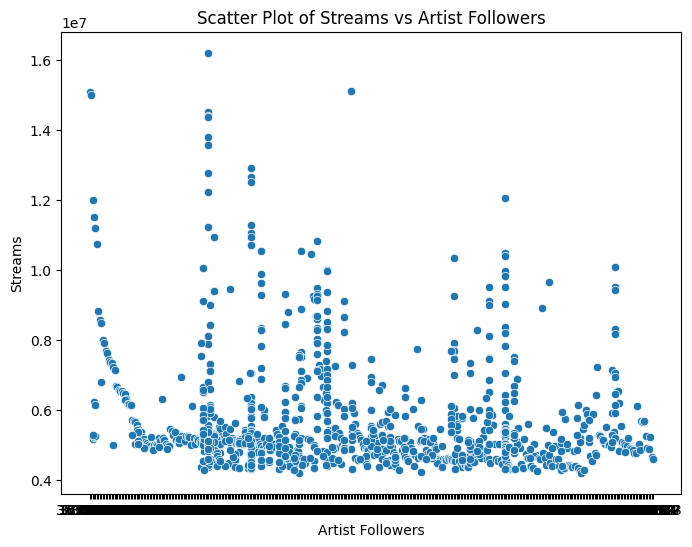

In [299]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_spotify_filtered, x='Artist Followers', y='Streams')
plt.xlabel('Artist Followers')
plt.ylabel('Streams')
plt.title("Scatter Plot of Streams vs Artist Followers")


plt.show()

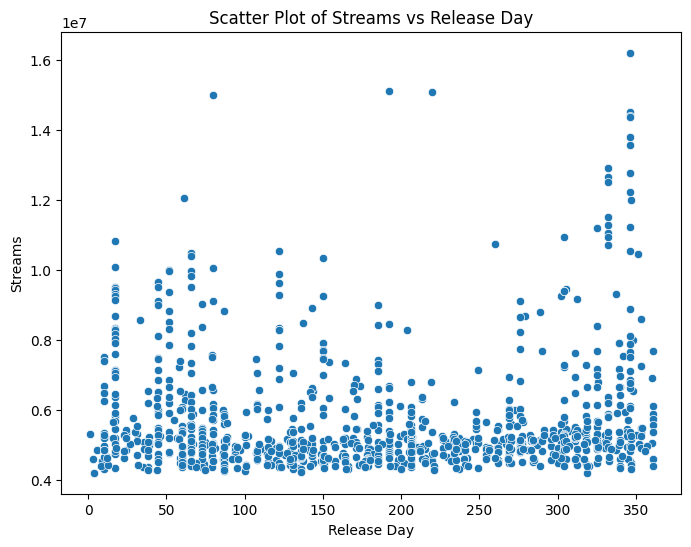

In [300]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_spotify_filtered, x='Day of Year', y='Streams')
plt.xlabel('Release Day')
plt.ylabel('Streams')
plt.title("Scatter Plot of Streams vs Release Day")


plt.show()

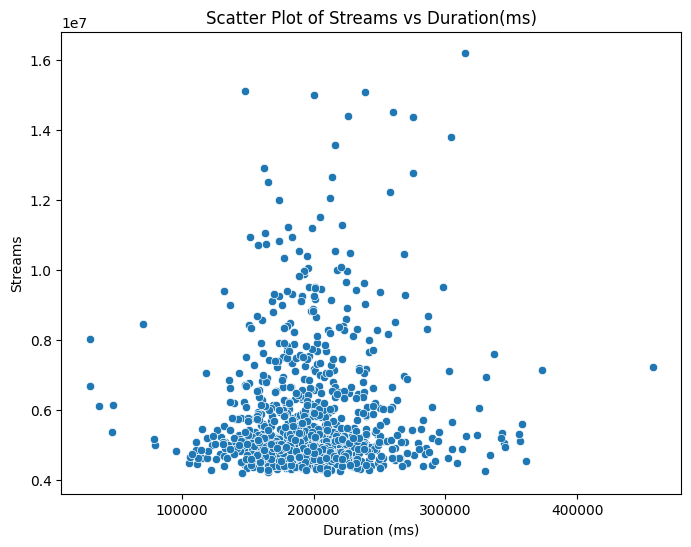

In [301]:
df_spotify_filtered['Duration (ms)'] = pd.to_numeric(df_spotify_filtered['Duration (ms)'])

# Define the tick positions
tick_range = np.linspace(25000, 460000, num=6)

# Your scatterplot code
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_spotify_filtered, x='Duration (ms)', y='Streams')
plt.xlabel('Duration (ms)')
plt.ylabel('Streams')
plt.title("Scatter Plot of Streams vs Duration(ms)")

plt.show()

The next three charts are bar graphs of feature importance for each model. As we can see, XGBoost incorporates the features more evenly than the other two.

In [302]:
# Create a sorted DataFrame by importance values
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

feature_importances_rf = feature_importances_rf[::-1]

# Plot the feature importance values using Plotly Express
fig = px.bar(feature_importances_rf, x='Importance', y='Feature', orientation='h',
             title='Feature Importance Plot for Random Forest Model',
             labels={'Importance': 'Importance', 'Feature': 'Feature'})
fig.show()

In [303]:
# Create a sorted DataFrame by importance values
feature_importances_dt = feature_importances_dt.sort_values(by='Importance', ascending=False)

feature_importances_dt = feature_importances_dt[::-1]

# Plot the feature importance values using Plotly Express
fig = px.bar(feature_importances_dt, x='Importance', y='Feature', orientation='h',
             title='Feature Importance Plot for Decision Tree Model',
             labels={'Importance': 'Importance', 'Feature': 'Feature'})
fig.show()

In [304]:
# Create a sorted DataFrame by importance values
feature_importances_xgb = feature_importances_xgb.sort_values(by='Importance', ascending=False)

feature_importances_xgb = feature_importances_xgb[::-1]

# Plot the feature importance values using Plotly Express
fig = px.bar(feature_importances_xgb, x='Importance', y='Feature', orientation='h',
             title='Feature Importance Plot for XG Boost Model',
             labels={'Importance': 'Importance', 'Feature': 'Feature'})
fig.show()

In conclusion, the lowest RMSE values are for a decision tree model with a depth of three and an XG Boost model with a depth of one. The RMSEs for these models range between 1.5 to 1.6 million streams. XG Boost also consistently keeps all feature importances above at least 5% whereas the random forest and decision tree models have features that have zero importance depending on the training set. Given all of that, I prefer the XG Boost with a depth of one model.

##What's next?

I mentioned above how I encoded the chord feature, but it didn't improve the model. Encoding other variables, particularly genre, might yield a lower RMSE. More precise data apropos the streams feature could be useful as well. If we were able to see streams for a set period after release, that could indicate popularity better than a cumulative number where older songs have a built-in advantage.